In [127]:
import matplotlib.pyplot as plt # plotting library
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)




tensor(0.9961)


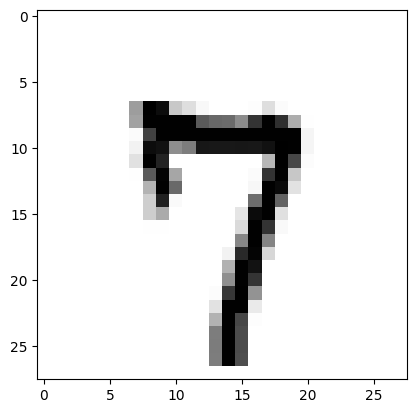

In [128]:
sample = train_data[0][0]
print(torch.max(sample))
plt.imshow(sample.reshape(28,28), cmap='Greys')
plt.show()

In [163]:
class Encoder(nn.Module):
    
    def __init__(self, h_size):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 64, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, h_size)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, h_size):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(h_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 3 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    

encoder = Encoder(2)
decoder = Decoder(2)

In [164]:
with torch.no_grad():
    print(encoder.encoder_cnn(sample.reshape(1,1,28,28)).shape)
    print(encoder(sample.reshape(1,1,28,28)))

torch.Size([1, 64, 3, 3])
tensor([[-0.0545,  0.1174]])


In [165]:
import torch.optim as optim


encoder.to('cuda')
decoder.to('cuda')

encoder.train()
decoder.train()


criterion = nn.MSELoss()

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        encoded_data = encoder(inputs)
        decoded_data = decoder(encoded_data)
        loss = criterion(decoded_data, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:    # print every 200 mini-batches
            print(f'epoch: {epoch + 1}, minibatch: {i:5d} loss: {running_loss:.3f}')
            running_loss = 0.0

print('Finished Training')


epoch: 1, minibatch:    49 loss: 8.656
epoch: 1, minibatch:    99 loss: 4.888
epoch: 1, minibatch:   149 loss: 3.574
epoch: 2, minibatch:    49 loss: 2.801
epoch: 2, minibatch:    99 loss: 2.607
epoch: 2, minibatch:   149 loss: 2.486
epoch: 3, minibatch:    49 loss: 2.284
epoch: 3, minibatch:    99 loss: 2.177
epoch: 3, minibatch:   149 loss: 2.118
epoch: 4, minibatch:    49 loss: 2.045
epoch: 4, minibatch:    99 loss: 2.017
epoch: 4, minibatch:   149 loss: 1.986
epoch: 5, minibatch:    49 loss: 1.955
epoch: 5, minibatch:    99 loss: 1.934
epoch: 5, minibatch:   149 loss: 1.918
epoch: 6, minibatch:    49 loss: 1.904
epoch: 6, minibatch:    99 loss: 1.887
epoch: 6, minibatch:   149 loss: 1.881
epoch: 7, minibatch:    49 loss: 1.866
epoch: 7, minibatch:    99 loss: 1.853
epoch: 7, minibatch:   149 loss: 1.845
epoch: 8, minibatch:    49 loss: 1.834
epoch: 8, minibatch:    99 loss: 1.832
epoch: 8, minibatch:   149 loss: 1.824
epoch: 9, minibatch:    49 loss: 1.814
epoch: 9, minibatch:    9

tensor([[0.6172, 1.0268]], device='cuda:0')


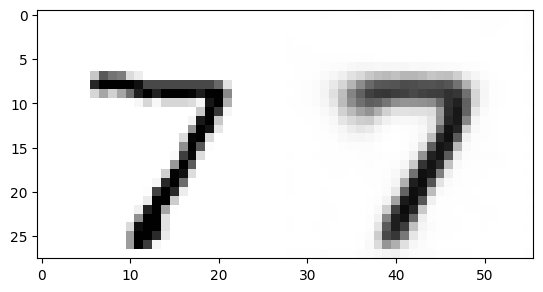

In [167]:
with torch.no_grad():
    sample = test_dataset[0][0]

    encoded = encoder(sample.reshape(1,1,28,28).cuda())
    print(encoded)
    decoded = decoder(encoded).cpu()
    tensor_grid = torch.cat([sample.reshape(28,28), decoded.reshape(28,28)], dim=1)
    plt.imshow(tensor_grid, cmap='Greys')
    plt.show()

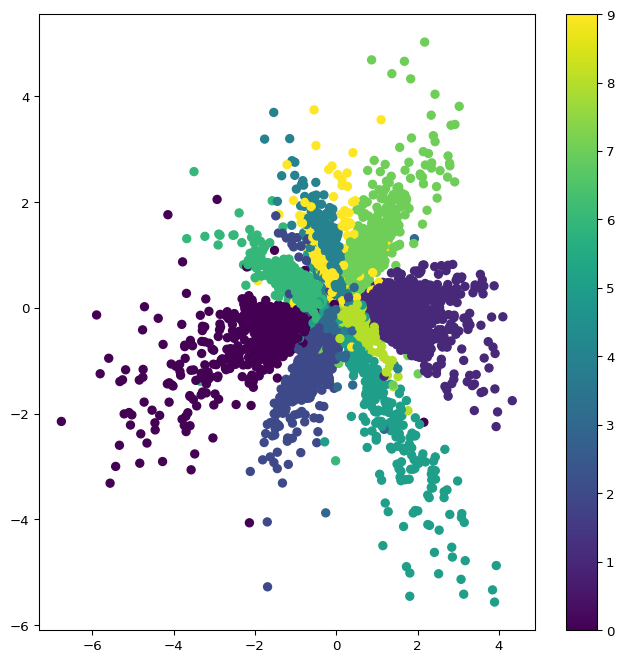

In [170]:
with torch.no_grad():
    x = []
    y = []
    l = []
    for test_data, labels in test_loader:
        encoded = encoder(test_data.cuda()).cpu()
        x.extend(encoded[:,0])
        y.extend(encoded[:,1])
        l.extend(labels)

my_dpi = 96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.scatter(x, y, c=l)

plt.axis('off')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.savefig("output.png")

plt.axis('on')
plt.colorbar()
plt.show()


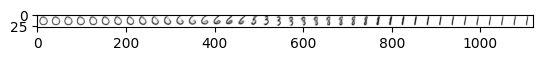

In [171]:
with torch.no_grad():
    def create_number(x,y):
        encoded = torch.tensor([[x,y]], dtype=torch.float32).cuda()
        decoded = decoder(encoded).detach().cpu()
        return decoded.reshape(28,28)

    transitor = torch.Tensor()

    for x in range(-20,20,1):
        x = x/10
        transitor = torch.cat([transitor,create_number(x,0)],dim=1)

    plt.imshow(transitor, cmap="Greys")
    plt.show()




# Model Saving/loading

### Save the models

In [177]:
torch.save(encoder.state_dict(), "models/encoder.pt")
torch.save(decoder.state_dict(), "models/decoder.pt")

### Load the models

In [182]:
encoder = Encoder(2).cuda()
encoder.load_state_dict(torch.load("models/encoder.pt"))

decoder = Decoder(2).cuda()
decoder.load_state_dict(torch.load("models/decoder.pt"))
print("Models loaded")

Models loaded


# Animation creator

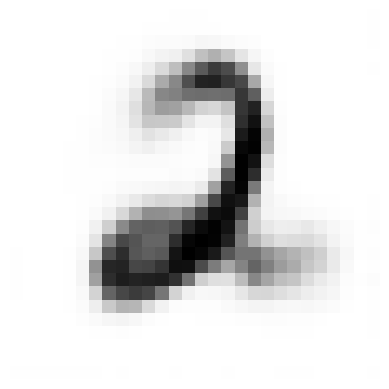

In [183]:
import tkinter as tk
from PIL import Image, ImageTk
from IPython.display import clear_output

generated_figures = 0

def on_click(event):
    global generated_figures
    # Calcular la posición relativa del clic
    relative_x = event.x / window.winfo_width()
    relative_y = 1 - event.y / window.winfo_height()
    shown_number = create_number(relative_x * (x_max - x_min) + x_min, relative_y * (y_max - y_min) + y_min)
    clear_output()
    plt.imshow(shown_number, cmap="Greys")
    plt.axis('off')
    plt.savefig("animation/" +str(generated_figures) + ".png")
    plt.show()
    generated_figures +=1

# Crear la ventana
window = tk.Tk()
window.geometry('1000x1000')  # Tamaño de la ventana

image = Image.open("output.png")  # Asegúrate de que 'img.png' está en la misma carpeta que este script
image = image.resize((1000, 1000), Image.ADAPTIVE)  # Ajustar al tamaño de la ventana
background_image = ImageTk.PhotoImage(image)

background_label = tk.Label(window, image=background_image)
background_label.place(x=0, y=0, relwidth=1, relheight=1)

# Evento de clic
window.bind('<Button-1>', on_click)

# Ejecutar la ventana
window.mainloop()

In [157]:
import cv2
import os

image_folder = 'animation'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=lambda x: int(x.split('.')[0]))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png'